In [5]:
from path import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from typing import Tuple, Union

## [imutils](https://github.com/PyImageSearch/imutils/blob/master/imutils/convenience.py)

In [ ]:
def rotate_bound(image, angle):
    """旋转图片并且不裁剪原图"""
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width and height:
        dim = (width, height)
    elif height:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

## 前景处理

In [88]:
def png2jpg_alpha0(img_path: Path) -> None:
    """
    # 原图为ps扣取的前景
    # 前景转jpg,将alpha通道为0的像素置0
    img_path: png路径
    jpg_dst_dir: jpg存储路径
    """
    if img_path.ext.lower() != ".png":
        return
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if not img[i, j][-1]:
                img[i, j, :] &= 0
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return img


# png2jpg_alpha0(img_fg_path)
def cut_forwardground(img_path: Path, mask_path: Path, jpg_save_dir: Path) -> None:
    """裁剪前景
    img_path: 图片路径
    mask_path: 标签路径
    jpg_save_dir: 前景保存文件夹
    """
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)
    _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    img = cv2.bitwise_and(img, img, mask=mask)
    from skimage import measure

    label_image = measure.label(mask, connectivity=2)
    regionprops = measure.regionprops(label_image)
    regions = [region.bbox for region in regionprops]
    for i, (ymin, xmin, ymax, xmax) in enumerate(regions):
        fg = img[ymin:ymax, xmin:xmax]
        cv2.imwrite(f"{jpg_save_dir}/{img_path.stem}_{i}.jpg", fg)


def padding(
    img: np.ndarray,
    newsize: Tuple[int, int],
    value: Union[int, Tuple[int, int, int]] = 0,
    center: bool = True,
):
    """
    对图片填充
    img: cv2图片
    newsize: [width,height]
    value: 填充值
    center: 图片是否居中
    """
    h, w = img.shape[:2]
    nw, nh = newsize
    if nw <= w or nh <= h:
        return img
    if center:
        top = (nh - h) // 2
        left = (nw - w) // 2
    else:
        top = random.randint(0, nh - h)
        left = random.randint(0, nw - w)
    bottom = nh - top - h
    right = nw - left - w
    return cv2.copyMakeBorder(
        img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=value
    )


def overlay(img_path: Path, mask_path: Path, save_dir: Path):
    """
    将mask叠加在原图上
    """
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    res = cv2.add(img, mask)
    # res = cv2.addWeighted(img,0.8,mask,0.2,0)
    # res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    return res


def multi_img(imgs_dir: Path, useresize=True):
    """
    多前景拼接
    imgs_dir: 前景文件夹
    """
    imgs = imgs_dir.files()
    random.shuffle(imgs)
    imgs = [cv2.imread(im) for im in imgs[: random.randint(2, min(len(imgs), 4))]]
    # 图片旋转
    imgs = [rotate_bound(im, random.randint(0, 90)) for im in imgs]
    # 图片统一大小
    size = [im.shape[:2] for im in imgs]
    maxh, maxw = map(max, zip(*size))
    h, w = random.randint(10, 100), random.randint(10, 100)
    if useresize:
        imgs = [resize(im, maxw + w, maxh + h) for im in imgs]
    else:
        imgs = [padding(im, (maxw + w, maxh + h)) for im in imgs]

    if len(imgs) % 2:
        imgs.append(np.zeros_like(imgs[0]))

    res = []
    for i in range(0, len(imgs), 2):
        res.append(np.hstack(imgs[i : i + 2]))  # np.hstack() 横向拼接,要求宽度一致
    res = np.vstack(res)  # np.vstack() 纵向拼接,要求长度一致
    # res=cv2.cvtColor(res,cv2.COLOR_BGR2RGB)
    return res


# img=Path(r'D:\Downloads\cables\bg000_c001.jpg')
# mask=Path(r'D:\Downloads\cables\bg000_c001.png')
# cut_forwardground(img,mask,Path(r'D:\Downloads\cables'))

## 图片叠加

In [6]:
def merge_img(
    img_bg_path: Path,
    img_fg_path: Path,
    img_dst_dir: Path,
    mask_dst_dir: Path,
    rotate=False,
    multi=False,
):
    """
    需要先将前景中的alpha通道进行处理,再调用当前函数
    img_bg_path: 背景图片路径
    img_fg_path: 前景图片路径
    img_dst_dir: 合并图片存储路径
    mask_dst_dir: 分割标签存储路径
    """
    if img_fg_path.ext != ".jpg":
        return
    # cv2不能读取中文路径
    img_bg = cv2.imdecode(np.fromfile(img_bg_path, dtype=np.uint8), cv2.IMREAD_COLOR)

    if multi:
        img_fg = multi_img(img_fg_path.dirname())
    else:
        img_fg = cv2.imdecode(
            np.fromfile(img_fg_path, dtype=np.uint8), cv2.IMREAD_COLOR
        )
    if rotate:
        img_fg = rotate_bound(img_fg, random.randint(0, 60))
    h_bg, w_bg = img_bg.shape[:2]
    h_fg, w_fg = img_fg.shape[:2]
    # fxy 前景放大倍数 (0.75,1.25),
    # fxy=(random.random()*0.5+0.75)*(0.5*h_bg/h_fg)
    fxy = (random.random() * 0.3 + 0.7) * (h_bg / h_fg)

    img_fg_resize = cv2.resize(
        img_fg, dsize=None, fx=fxy, fy=fxy, interpolation=cv2.INTER_LINEAR
    )

    h_fgr, w_fgr = img_fg_resize.shape[:2]
    if h_bg < h_fgr or w_bg < w_fgr:
        return
    # 上下偏移
    # offset_h=h_bg-h_fgr
    offset_h = random.randint(0, h_bg - h_fgr)
    # 左右偏移
    # offset_w=random.randint((w_bg-w_fgr)//5*2,(w_bg-w_fgr)//5*3)
    offset_w = random.randint(0, w_bg - w_fgr)
    # 填充区域
    roi = img_bg[offset_h : offset_h + h_fgr :, offset_w : offset_w + w_fgr]

    # 创建掩膜
    img_fg_gray = cv2.cvtColor(img_fg_resize, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(img_fg_gray, 1, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # roi中mask区域变黑色
    roi_without_mask = cv2.bitwise_and(roi, roi, mask=mask_inv)
    # 进行融合
    img_fg_resize = cv2.cvtColor(img_fg_resize, cv2.COLOR_BGR2RGB)
    dst = cv2.add(roi_without_mask, img_fg_resize)
    # 融合后放在原图上
    img_bg[offset_h : offset_h + h_fgr :, offset_w : offset_w + w_fgr] = dst
    img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

    img_dst_path = f"{img_dst_dir}/{img_bg_path.stem}_{img_fg_path.stem}.jpg"
    cv2.imwrite(img_dst_path, img_bg)

    # 生成分割标签
    mask_png_r = np.zeros(img_bg.shape[:2])
    mask_png_gb = mask_png_r.copy()
    mask_png_r[offset_h : offset_h + h_fgr :, offset_w : offset_w + w_fgr] = mask
    # 生成BGR
    mask_png = cv2.merge([mask_png_gb, mask_png_gb, mask_png_r])

    mask_dst_path = f"{mask_dst_dir}/{img_bg_path.stem}_{img_fg_path.stem}.png"
    cv2.imwrite(mask_dst_path, mask_png)


# plt.imshow()
# merge_img(Path(r'D:\Downloads\cables\bg\bg000.jpg'),Path(r'D:\Downloads\cables\cablejpg\c001.jpg'),Path('D:\Downloads\cables'),Path('D:\Downloads\cables'),True,True)

In [ ]:
mk=lambda x:x.mkdir() if not x.exists() else None
root=Path(r'D:\Downloads\Capacitors')
cap=root/'Capacitor'
voc=root/'voc'
capjpg =root/'catjpg'
mk(capjpg)
jpeg=root/'newvoc/JPEGImages'
masks=root/'newvoc/Segmentation'
mk(jpeg)
mk(masks)
bg=root/'bg'
for b in bg.files():
    for i in range(1,300):
        f=capjpg/f'{i}.jpg'
        merge_img(b,f,jpeg,masks,multi=True)  


# for im in cable.files():
#     png2jpg_alpha0(im,cablejpg)
# for im_bg in bg.files():
#     for im_fg in cablejpg.files():
#         merge_img(im_bg,im_fg,jpeg,masks)


## albumentations

In [ ]:
from albumentations import HorizontalFlip,RandomBrightnessContrast,rotate
img_path=jpeg/'bg004_c037.jpg'
mask_path = masks/'bg004_c037.png'
read=lambda x:cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
image = read(img_path)
mask = read(mask_path)
image1 = RandomBrightnessContrast(p=1)(image=image,mask=mask)
plt.subplot(1,2,1)
plt.imshow(image1['image'])
plt.subplot(1,2,2)
plt.imshow(image1['mask'])

## [yolov6](https://github.com/meituan/YOLOv6/blob/main/yolov6/data/data_augment.py)

In [7]:
#!/usr/bin/env python3
# -*- coding:utf-8 -*-
# This code is based on
# https://github.com/ultralytics/yolov5/blob/master/utils/dataloaders.py


import math
import random

import cv2
import numpy as np


def augment_hsv(im, hgain=0.5, sgain=0.5, vgain=0.5):
    """HSV color-space augmentation.hsv增强"""
    if hgain or sgain or vgain:
        r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))
        dtype = im.dtype  # uint8

        x = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        im_hsv = cv2.merge(
            (cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))
        )
        cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=im)  # no return needed


def letterbox(
    im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32
):
    """长边变成640,短边按比例缩小并填充"""
    """Resize and pad image while meeting stride-multiple constraints."""
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    elif isinstance(new_shape, list) and len(new_shape) == 1:
        new_shape = (new_shape[0], new_shape[0])

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border

    return im, r, (left, top)


def mixup(im, labels, im2, labels2):
    """Applies MixUp augmentation https://arxiv.org/pdf/1710.09412.pdf."""
    """图片按权重融合"""
    r = np.random.beta(32.0, 32.0)  # mixup ratio, alpha=beta=32.0
    im = (im * r + im2 * (1 - r)).astype(np.uint8)
    labels = np.concatenate((labels, labels2), 0)
    return im, labels


def random_affine(
    img, labels=(), degrees=10, translate=0.1, scale=0.1, shear=10, new_shape=(640, 640)
):
    """Applies Random affine transformation."""
    """仿射变换"""

    def box_candidates(box1, box2, wh_thr=2, ar_thr=20, area_thr=0.1, eps=1e-16):
        # box1(4,n), box2(4,n)
        """Compute candidate boxes: box1 before augment, box2 after augment, wh_thr (pixels), aspect_ratio_thr, area_ratio."""
        w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
        w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
        ar = np.maximum(w2 / (h2 + eps), h2 / (w2 + eps))  # aspect ratio
        return (
            (w2 > wh_thr)
            & (h2 > wh_thr)
            & (w2 * h2 / (w1 * h1 + eps) > area_thr)
            & (ar < ar_thr)
        )  # candidates

    def get_transform_matrix(img_shape, new_shape, degrees, scale, shear, translate):
        new_height, new_width = new_shape
        # Center
        C = np.eye(3)
        C[0, 2] = -img_shape[1] / 2  # x translation (pixels)
        C[1, 2] = -img_shape[0] / 2  # y translation (pixels)

        # Rotation and Scale
        R = np.eye(3)
        a = random.uniform(-degrees, degrees)
        # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
        s = random.uniform(1 - scale, 1 + scale)
        # s = 2 ** random.uniform(-scale, scale)
        R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

        # Shear
        S = np.eye(3)
        S[0, 1] = math.tan(
            random.uniform(-shear, shear) * math.pi / 180
        )  # x shear (deg)
        S[1, 0] = math.tan(
            random.uniform(-shear, shear) * math.pi / 180
        )  # y shear (deg)

        # Translation
        T = np.eye(3)
        T[0, 2] = (
            random.uniform(0.5 - translate, 0.5 + translate) * new_width
        )  # x translation (pixels)
        T[1, 2] = (
            random.uniform(0.5 - translate, 0.5 + translate) * new_height
        )  # y transla ion (pixels)

        # Combined rotation matrix
        M = T @ S @ R @ C  # order of operations (right to left) is IMPORTANT
        return M, s

    n = len(labels)
    if isinstance(new_shape, int):
        height = width = new_shape
    else:
        height, width = new_shape

    M, s = get_transform_matrix(
        img.shape[:2], (height, width), degrees, scale, shear, translate
    )
    if (M != np.eye(3)).any():  # image changed
        img = cv2.warpAffine(
            img, M[:2], dsize=(width, height), borderValue=(114, 114, 114)
        )

    # Transform label coordinates
    if n:
        new = np.zeros((n, 4))

        xy = np.ones((n * 4, 3))
        xy[:, :2] = labels[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(
            n * 4, 2
        )  # x1y1, x2y2, x1y2, x2y1
        xy = xy @ M.T  # transform
        xy = xy[:, :2].reshape(n, 8)  # perspective rescale or affine

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # clip
        new[:, [0, 2]] = new[:, [0, 2]].clip(0, width)
        new[:, [1, 3]] = new[:, [1, 3]].clip(0, height)

        # filter candidates
        i = box_candidates(box1=labels[:, 1:5].T * s, box2=new.T, area_thr=0.1)
        labels = labels[i]
        labels[:, 1:5] = new[i]

    return img, labels


def mosaic_augmentation(
    shape,
    imgs,
    hs,
    ws,
    labels,
    hyp,
    specific_shape=False,
    target_height=640,
    target_width=640,
):
    """Applies Mosaic augmentation.马赛克增强"""
    assert (
        len(imgs) == 4
    ), "Mosaic augmentation of current version only supports 4 images."
    labels4 = []
    if not specific_shape:
        if isinstance(shape, list) or isinstance(shape, np.ndarray):
            target_height, target_width = shape
        else:
            target_height = target_width = shape

    yc, xc = (
        int(random.uniform(x // 2, 3 * x // 2)) for x in (target_height, target_width)
    )  # mosaic center x, y

    for i in range(len(imgs)):
        # Load image
        img, h, w = imgs[i], hs[i], ws[i]
        # place img in img4
        if i == 0:  # top left
            img4 = np.full(
                (target_height * 2, target_width * 2, img.shape[2]), 114, dtype=np.uint8
            )  # base image with 4 tiles

            x1a, y1a, x2a, y2a = (
                max(xc - w, 0),
                max(yc - h, 0),
                xc,
                yc,
            )  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = (
                w - (x2a - x1a),
                h - (y2a - y1a),
                w,
                h,
            )  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, target_width * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(target_height * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = (
                xc,
                yc,
                min(xc + w, target_width * 2),
                min(target_height * 2, yc + h),
            )
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b

        # Labels
        labels_per_img = labels[i].copy()
        if labels_per_img.size:
            boxes = np.copy(labels_per_img[:, 1:])
            boxes[:, 0] = (
                w * (labels_per_img[:, 1] - labels_per_img[:, 3] / 2) + padw
            )  # top left x
            boxes[:, 1] = (
                h * (labels_per_img[:, 2] - labels_per_img[:, 4] / 2) + padh
            )  # top left y
            boxes[:, 2] = (
                w * (labels_per_img[:, 1] + labels_per_img[:, 3] / 2) + padw
            )  # bottom right x
            boxes[:, 3] = (
                h * (labels_per_img[:, 2] + labels_per_img[:, 4] / 2) + padh
            )  # bottom right y
            labels_per_img[:, 1:] = boxes

        labels4.append(labels_per_img)

    # Concat/clip labels
    labels4 = np.concatenate(labels4, 0)
    # for x in (labels4[:, 1:]):
    #     np.clip(x, 0, 2 * s, out=x)
    labels4[:, 1::2] = np.clip(labels4[:, 1::2], 0, 2 * target_width)
    labels4[:, 2::2] = np.clip(labels4[:, 2::2], 0, 2 * target_height)

    # Augment
    img4, labels4 = random_affine(
        img4,
        labels4,
        degrees=hyp["degrees"],
        translate=hyp["translate"],
        scale=hyp["scale"],
        shear=hyp["shear"],
        new_shape=(target_height, target_width),
    )

    return img4, labels4

In [ ]:
# 马赛克增强
# YOLOX的训练过程分为两阶段
# 第一阶段是基于强马赛克增强的训练,共284ep
# 第二阶段是关闭马赛克增强的训练,共16ep
hyp = dict(
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,
)
img_paths = Path(r"D:\dataset\Capacitors\bg").files()


def load_image(i):
    im = cv2.imread(img_paths[i])
    return im, im.shape[:2], im.shape[:2]


def label(i):
    return np.array([[0, 0.1, 0.2, 0.3, 0.4]])


def get_mosaic(index, shape):
    """Gets images and labels after mosaic augments"""
    indices = [index] + random.choices(
        range(0, len(img_paths)), k=3
    )  # 3 additional image indices
    random.shuffle(indices)
    imgs, hs, ws, labels = [], [], [], []
    for index in indices:
        img, _, (h, w) = load_image(index)
        labels_per_img = label(index)
        imgs.append(img)
        hs.append(h)
        ws.append(w)
        labels.append(labels_per_img)
    img, labels = mosaic_augmentation(shape, imgs, hs, ws, labels, hyp)
    return img, labels


img, label = get_mosaic(1, [640, 640])
plt.imshow(img)
label

## 直方图均衡/伽马变换

In [4]:
# cv2.equalizeHist(img_gray)
def histEq(img_gray):
    """直方图均衡,增加图像的全局对比度"""
    hist = np.bincount(img_gray.ravel(), minlength=256)
    hist_norm = hist / hist.sum()
    hist_cdf = hist_norm.cumsum()
    gray_img = img_gray.copy()
    for i in range(0, 256):
        gray_img[img_gray == i] = 255 * hist_cdf[i]
    gray_img = np.clip(gray_img.astype(np.uint8), 0, 255)
    return gray_img


def gammaTransform(img_gray, vmin=0, vmax=255, gamma=1.0):
    """灰度变换(伽马变换),gamma<1,提高亮度,gamma>1,降低亮度"""
    normImg = lambda x: vmin + (vmax - vmin) * (x - x.min()) / (
        x.max() - x.min() + 1e-6
    )  # 归一化

    imgGamma = np.power(img_gray.astype(np.float64), gamma)
    imgGamma = np.clip(normImg(imgGamma).astype(np.uint8), 0, 255)
    return imgGamma


def showHist(im):
    grayHist = cv2.calcHist(
        images=[im], channels=[0], mask=None, histSize=[256], ranges=[0, 256]
    )
    plt.plot(range(256), grayHist, linewidth=1.5, c="red")
    y_maxValue = np.max(grayHist)
    plt.axis([0, 255, 0, y_maxValue])  # x和y的范围
    plt.xlabel("gray Level")
    plt.ylabel("Number Of Pixels")
    plt.show()

## 泊松融合

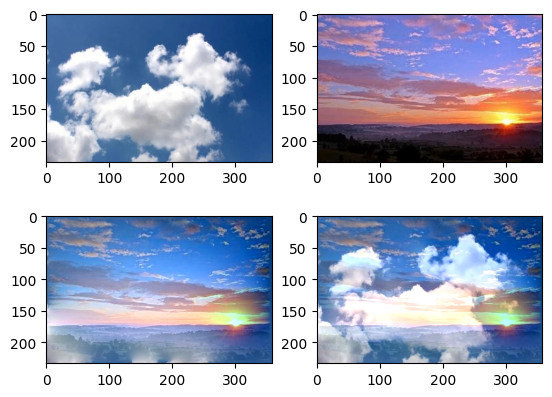

In [3]:
# Read images : src image will be cloned into dst
dst = cv2.imread(r"D:\dataset\cloud\000070.jpg")
obj = cv2.imread(r"D:\dataset\cloud\000049.jpg")
dst = cv2.resize(dst, (358, 234))
obj = cv2.resize(obj, (358, 234))
# Create an all white mask
mask = 255 * np.ones(obj.shape, obj.dtype)

# The location of the center of the src in the dst
width, height, channels = dst.shape
center = (height // 2, width // 2)

# Seamlessly clone src into dst and put the results in output
normal_clone = cv2.seamlessClone(
    src=obj, dst=dst, mask=mask, p=center, flags=cv2.NORMAL_CLONE
)
mixed_clone = cv2.seamlessClone(
    src=obj, dst=dst, mask=mask, p=center, flags=cv2.MIXED_CLONE
)

dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
obj = cv2.cvtColor(obj, cv2.COLOR_BGR2RGB)

normal = cv2.cvtColor(normal_clone, cv2.COLOR_BGR2RGB)
mixed = cv2.cvtColor(mixed_clone, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(dst)
ax[0][1].imshow(obj)
ax[1][0].imshow(normal)
ax[1][1].imshow(mixed)

## 大津法OSTU

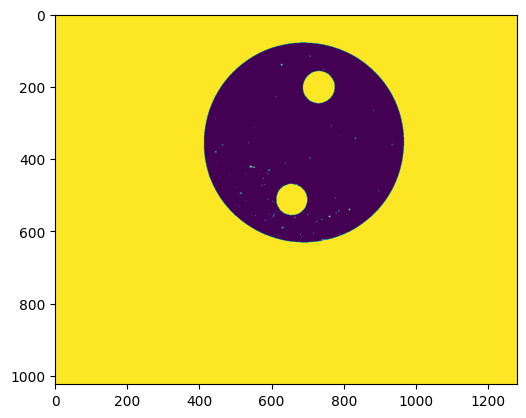

In [4]:
img = cv2.imread(r"D:\dataset\plugpic\plug\ok\1.png",0)
_,mask=cv2.threshold(src=img,thresh=0,maxval=255,type=cv2.THRESH_OTSU)
plt.imshow(mask)

## 分水岭算法
从极小值开始灌水，在极大值筑水坝，避免两边相连，水坝为求的边缘

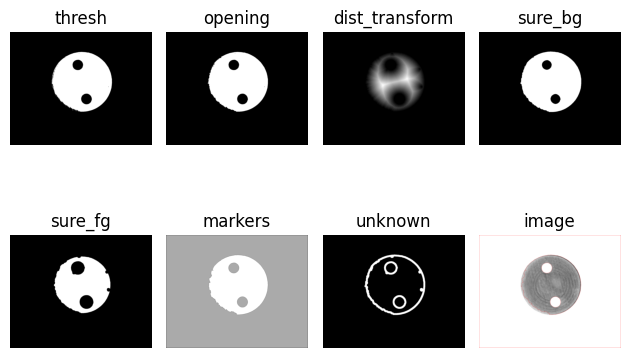

In [3]:
# 读取图像并转为灰度图像
image = cv2.imread(r"D:\dataset\plugpic\plug\ok\V3.F10.OK1.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 对灰度图像进行阈值分割
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 对二值图像进行形态学操作，去除噪点
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(
    dist_transform, 0.1 * dist_transform.max(), 255, cv2.THRESH_BINARY
)
sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

names = [
    "thresh",
    "opening",
    "dist_transform",
    "sure_bg",
    "sure_fg",
    "markers",
    "unknown",
    "image",
]
ims = [thresh, opening, dist_transform, sure_bg, sure_fg, markers, unknown, image]
for i in range(len(ims)):
    plt.subplot(2, len(ims)//2, i + 1)
    plt.axis("off")
    plt.title(names[i])
    if names[i] == "image":
        plt.imshow(ims[i])
    else:
        plt.imshow(ims[i], cmap="gray")
plt.tight_layout()
plt.show()

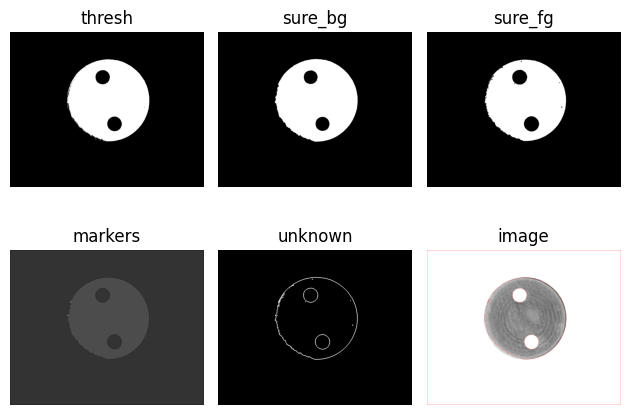

In [15]:
image = cv2.imread(r"D:\dataset\plugpic\plug\ok\V3.F10.OK1.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=2)  # sure background area
sure_fg = cv2.erode(opening, kernel, iterations=2)  # sure foreground area
unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

names = ["thresh", "sure_bg", "sure_fg", "markers", "unknown", "image"]
ims = [thresh, sure_bg, sure_fg, markers, unknown, image]
for i in range(len(ims)):
    plt.subplot(2, len(ims)//2, i + 1)
    plt.axis("off")
    plt.title(names[i])
    if names[i] == "image":
        plt.imshow(ims[i])
    else:
        plt.imshow(ims[i], cmap="gray")
plt.tight_layout()
plt.show()

## deepsort
[匈牙利算法](https://zh.wikipedia.org/wiki/%E5%8C%88%E7%89%99%E5%88%A9%E7%AE%97%E6%B3%95)
[卡尔曼滤波](https://www.zhihu.com/question/23971601)

## 高/低通滤波
频率低的地方说明它是比较平滑的，因为平滑的地方灰度值变化比较小，而频率高的地方通常是边缘或者噪声，因为这些地方往往是灰度值突变的
所谓高通滤波就是保留频率比较高的部分，即突出边缘；低通滤波就是保留频率比较低的地方，即平滑图像，弱化边缘，消除噪声。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


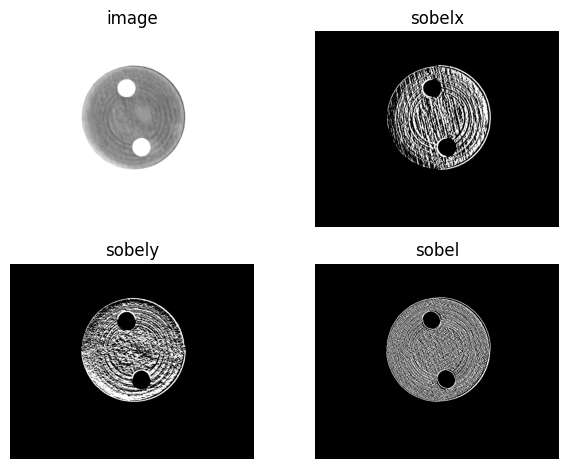

In [16]:

image = cv2.imread(r"D:\dataset\plugpic\plug\ok\V3.F10.OK1.png")

sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
sobel = cv2.Sobel(image,cv2.CV_64F,1,1,ksize=5)

names = [ "image",'sobelx','sobely','sobel']
ims = [image, sobelx,sobely,sobel]
for i in range(len(ims)):
    plt.subplot(2, len(ims)//2, i + 1)
    plt.axis("off")
    plt.title(names[i])
    if names[i] == "image":
        plt.imshow(ims[i])
    else:
        plt.imshow(ims[i], cmap="gray")
plt.tight_layout()
plt.show()